# 章節 9：二維空間

## 9.5 聯合分佈（Joint Distributions）

當分佈中每個數值是一組變量時，例如向量，這就稱為聯合分佈。因為它代表多個變數「一起出現」的分佈。聯合分佈包含變數的分佈以及變數之間的關聯資訊。

給定一個聯合分佈，我們可以計算單個變數的機率分佈，又稱作邊際分佈（Marginal Distribution）。

thinkbayes.Joint 類別提供一個方法計算邊際分佈：

<pre>
# class Joint:

def Marginal(self, i):

    # i 表示我們想知道的變數的索引值；漆彈例子來說 i=0 表示 alpha 的分佈, i=1 表示 beta 的分佈
    
    pmf = Pmf()
    for vs, prob in self.Items():
    pmf.Incr(vs[i], prob)
    return pmf
</pre>

下方是計算邊際機率的程式碼(有合併 9.4 小節以前的程式碼)：

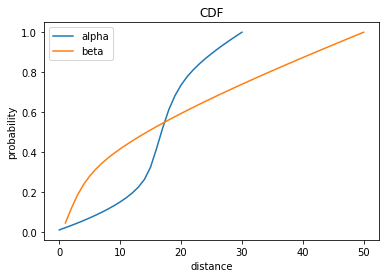

alpha 的中位數： 17


In [22]:
import thinkbayes as tb
import math
import matplotlib.pyplot as plt
import numpy as np


def plot_dist(dist, c=None):
    x, y = zip(*sorted(dist.Items()))
    plt.plot(x, y, c=c)

    
# Paintball 繼承自 Suite 以及 Joint
class Paintball(tb.Suite, tb.Joint):
    
    def __init__(self, alphas, betas, locations):
        # alphas：一序列的 alpha 值
        # betas：一序列的 beta 值
        
        # 所有可能漆彈的位置；為了之後 Likelihood 方法使用
        self.locations = locations
        
        # pairs：所有 alpha, beta 的配對
        pairs = [(alpha, beta)
            for alpha in alphas
            for beta in betas
        ]
        
        tb.Suite.__init__(self, pairs)
    
    
    def Likelihood(self, data, hypo):
        # alpha, beta：假設敵人的位置
        alpha, beta = hypo

        # x：觀察到的牆面漆彈位置
        x = data
        pmf = MakeLocationPmf(alpha, beta, self.locations)

        # 從建立好的 pmf 得到漆彈位置的似然性
        like = pmf.Prob(x)
        return like
        

# 計算每個位置被漆彈打到的機率，跟掃射速度成反比
def MakeLocationPmf(alpha, beta, locations):
    # alpha, beta：敵人的座標
    # locations：一序列牆上漆彈的位置

    pmf = tb.Pmf()
    for x in locations:
        prob = 1.0 / StrafingSpeed(alpha, beta, x)
        pmf.Set(x, prob)
        
    pmf.Normalize()
    # 回傳漆彈位置與其對應的機率
    return pmf       


def StrafingSpeed(alpha, beta, x):
    # alpha, beta：敵人的座標
    # x：牆上漆彈的位置
    
    
    theta = math.atan2(x - alpha, beta)
    speed = beta / math.cos(theta)**2
    
    # 回傳 x 對 theta 的微分
    return speed

alphas = range(0, 31)
betas = range(1, 51)
locations = range(0, 31)
suite = Paintball(alphas, betas, locations)

# 根據牆上漆彈位置更新先驗分佈
suite.UpdateSet([15, 16, 18, 21])

# 計算後驗的邊際分佈
marginal_alpha = suite.Marginal(0)
marginal_beta = suite.Marginal(1)

plot_dist(marginal_alpha.MakeCdf())
plot_dist(marginal_beta.MakeCdf())
plt.legend(["alpha", "beta"])
plt.title("CDF")
plt.xlabel("distance")
plt.ylabel("probability")
plt.show()

print("alpha 的中位數：", marginal_alpha.MakeCdf().Percentile(50))

上圖是 alpha, beta 各自邊際分佈的 CDF 圖。

alpha 的中位數是 17，約是觀察到的漆彈位置的質心。beta 最有可能的值是靠牆壁，但超過 10 英尺的分佈幾乎是呈現均勻分佈，表示觀察到的市值沒辦法有效的區分這些 beta 值的差異。

給定後驗邊際分佈，我們可以計算 alpha, beta 各自的可靠區間（credible interval）。

In [21]:
print('alpha 50% 可靠區間:', marginal_alpha.CredibleInterval(50))
print('beta 50% 可靠區間:', marginal_beta.CredibleInterval(50))

alpha 50% 可靠區間: (14, 21)
beta 50% 可靠區間: (5, 31)


觀察上方的靠靠區間得知敵人在體育館的邊邊附近。但沒有很強烈的證據。

如果是 90% 的可靠區間幾乎涵蓋了所有的體育館，看下方結果。

In [20]:
print('alpha 90% 可靠區間:', marginal_alpha.CredibleInterval(90))
print('beta 90% 可靠區間:', marginal_beta.CredibleInterval(90))

alpha 90% 可靠區間: (4, 28)
beta 90% 可靠區間: (2, 47)
